# Sophisticated inference on a Generalized T-Maze

This notebook demonstrates the effect of sophisticated inference on a generalized T-maze which has multiple cues, out of which only one leads to reward. Sophisticated inference correctly focuses on the cue that yields reward, whereas vanilla AIF will be distracted by the prospect of information gain of the other cues. However, due to the long planning horizon this takes a long time to compute doing the full tree search. See the mcts_generalized_tmaze example to see how to combat this using MCMC sampling.

In [1]:
%load_ext autoreload
%autoreload 2

from pymdp.envs.generalized_tmaze import (
    GeneralizedTMazeEnv, get_maze_matrix, parse_maze, render 
)
from pymdp.agent import Agent

import numpy as np 
import jax.numpy as jnp

from jax import random as jr

key = jr.PRNGKey(0)

In [2]:
key, subkey = jr.split(key)
M = get_maze_matrix(small=True)
env_info = parse_maze(M, subkey)
tmaze_env = GeneralizedTMazeEnv(env_info)

In [3]:
A = [a.copy() for a in tmaze_env.params["A"]]
B = [b.copy() for b in tmaze_env.params["B"]]
A_dependencies = tmaze_env.dependencies["A"]
B_dependencies = tmaze_env.dependencies["B"]

# [position], [cue], [reward]
C = [jnp.zeros(a.shape[:2]) for a in A]

rewarding_modality = 2 + env_info["num_cues"]

C[rewarding_modality] = C[rewarding_modality].at[:,1].set(2.0)
C[rewarding_modality] = C[rewarding_modality].at[:,2].set(-3.0)

D = [jnp.ones(b.shape[:2]) for b in B]
D[0] = tmaze_env.params["D"][0].copy()

agent = Agent(
    A, B, C, D, 
    None, None, None, 
    policy_len=1,
    A_dependencies=A_dependencies, 
    B_dependencies=B_dependencies,
    apply_batch=False
)

In [4]:
keys = jr.split(key, 2)
key = keys[0]
obs, tmaze_env = tmaze_env.reset(keys[1:])

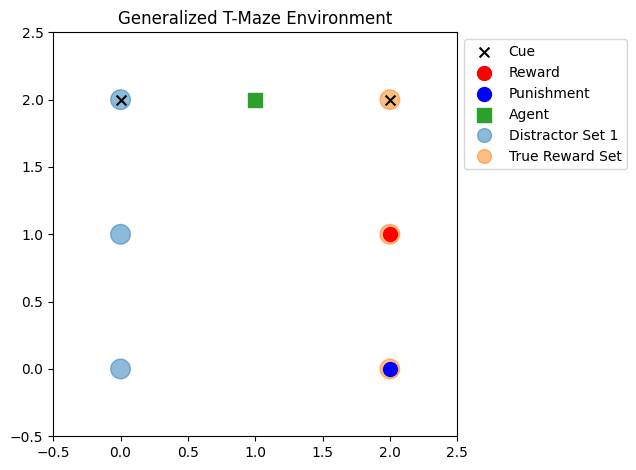

In [5]:
_ = render(env_info, tmaze_env)

In [6]:
qs = agent.infer_states(
    observations=obs,
    past_actions=None,
    empirical_prior=agent.D,
    qs_hist=None,
)

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

def observation_label(o):
    return "loc: " + str(o[0][0, 0]) + "\n cues: "+ str(o[1][0, 0])+","+str(o[2][0, 0]) + "\n rewards: "+ str(o[3][0, 0])+","+str(o[4][0, 0])

def policy_label(a):
    actions = ["down", "up", "left", "right", "stay"]
    return actions[a[0]]

def plot_plan_tree(
    tree,
    prob_threshold=0.2
):
    root_node = tree.root()

    colormap = plt.cm.Blues
    colormap_policy = plt.cm.Reds

    # create graph
    count = 0
    G = nx.Graph()
    to_visit = [(root_node, 0)]
    labels = {}
    colors = []

    G.add_node(count)
    labels[0] = ""
    colors.append((0.0, 0.0, 0.0, 1.0))
    count += 1

    # visit children
    while len(to_visit) > 0:
        node, id = to_visit.pop()
        for child in node["children"]:
            prob = child.get("prob", 0)
            if prob < prob_threshold:
                continue

            G.add_node(count)
            G.add_edge(id, count)

            cm = colormap
            if "policy" in child.keys():
                a = child["policy"]
                labels[count] = policy_label(a)
                cm = colormap_policy
            elif "observation" in child.keys():
                o = child["observation"]
                labels[count] = observation_label(o)
            else:
                labels[count] = ""


            r, g, b, a = cm(child.get("prob", 0))
            colors.append((r, g, b, 0.5))

            to_visit.append((child, count))
            count += 1.0


    pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
    nx.draw(
        G,
        pos,
        with_labels=True,
        font_size=8,
        labels=labels,
        node_color=colors,
    )

In [17]:
from pymdp.planning.si import tree_search

tree = tree_search(agent, qs, 3, entropy_prune_threshold=0.0, gamma=5)


When plotting the plan tree, the preferred plan is indeed to go to the right cue, and then fetch the reward.

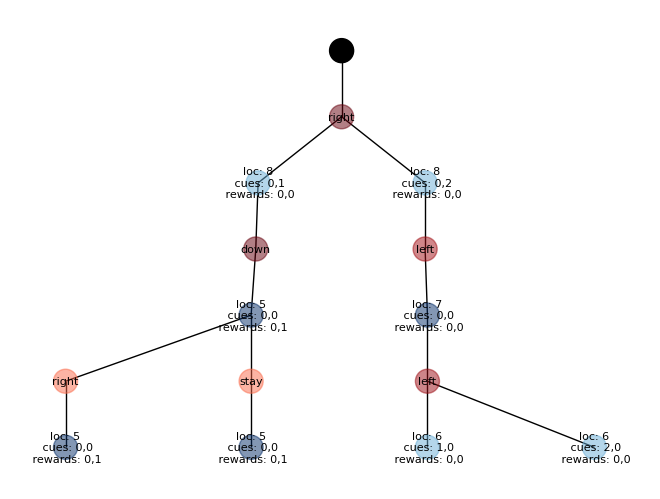

In [18]:
plot_plan_tree(tree, prob_threshold=0.1)

If we limit the planning horizon to a single step, we can see that indeed it renders both cues equally attractive.

In [10]:
tree = tree_search(agent, qs, 1, entropy_prune_threshold=0.0, gamma=5)

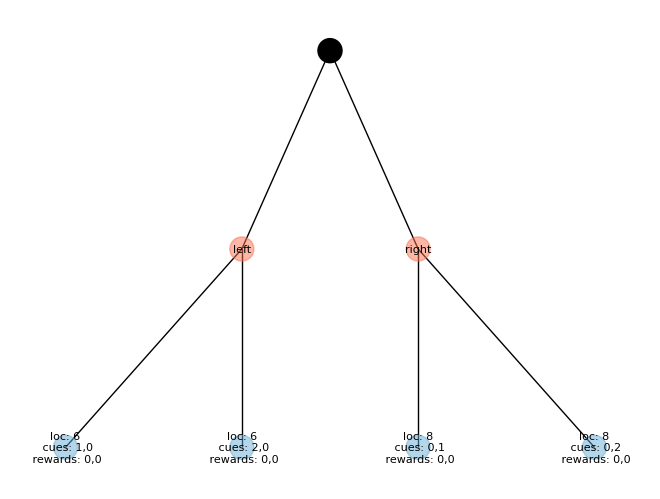

In [11]:
plot_plan_tree(tree, prob_threshold=0.1)